In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [3]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3727  100  3727    0     0   9225      0 --:--:-- --:--:-- --:--:--  9225
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.0a0+d6149a7:
  Successfully uninstalled torch-1.5.0a0+d6149a7
Uninstalling torchvision-0.6.0a0+3c254fb:
  Successfully uninstalled torchvision-0.6.0a0+3c254fb
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objects/114.5 MiB.               

In [4]:
import os
import json
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
import torch
import torchtext
from torchtext.data import Field, LabelField
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator
import spacy
import en_core_web_sm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import time
from collections import Counter
import tensorflow
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import io
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import sys
import shutil
import argparse
import tempfile
import urllib.request
import zipfile

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

path = "/content/drive/My Drive/Colab Notebooks/585_group/"

Using TensorFlow backend.


In [5]:
## Set seed of randomization and working device
manual_seed = 77
torch.manual_seed(manual_seed)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = xm.xla_device()
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)


xla:1


In [0]:
# reading in 100k data
df = pd.read_csv(path+"subset_100k.csv", index_col=0, encoding="utf-8").reset_index(drop=True)
train, validate, test = np.split(df.sample(frac=1, random_state=123).drop(columns="index"), 
                                                                          [int(.6*len(df)), int(.8*len(df))])
train_texts, train_labels = zip(*train.values) #resulting type is tuples
valid_texts, valid_labels = zip(*validate.values)
test_texts, test_labels = zip(*test.values)

In [7]:
# installing transformers since BERT resembles transformer encoder
! pip install transformers

In [0]:
from transformers import *

In [0]:
# define a function for data preparation
def data_prepare(file_path, tokenizer, max_len = 256, mode = 'train'):
    '''
    file_path: the path to input file. 
                In train mode, the input must be a tsv file that includes two columns where the first is text, and second column is label.
                The first row must be header of columns.

                In predict mode, the input must be a tsv file that includes only one column where the first is text.
                The first row must be header of column.

    lab2ind: dictionary of label classes
    tokenizer: BERT tokenizer
    max_len: maximal length of input sequence
    mode: train or predict
    '''
    # if we are in train mode, we will load two columns (i.e., text and label).
    if mode == 'train':
        # Use pandas to load dataset
        df = pd.read_csv(file_path, delimiter=',',header=0, names=['content','label'])
        print("Data size ", df.shape)
        labels = df.label.values
        
        # Create sentence and label lists
        labels = [i for i in labels] 
        print("Label is ", labels[0])
        
        # Convert data into torch tensors
        labels = torch.tensor(labels)

    # if we are in predict mode, we will load one column (i.e., text).
    elif mode == 'predict':
        df = pd.read_csv(file_path, delimiter=',',header=0, names=['content'])
        print("Data size ", df.shape)
        # create placeholder
        labels = []
    else:
        print("the type of mode should be either 'train' or 'predict'. ")
        return
        
    # Create sentence and label lists
    content = df.content.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in content:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    print("The first sentence untokenized:\n", content[0])
    print ("Index numbers of the first sentence after padding:\n",input_ids[0])

    return input_ids, labels, attention_masks

In [0]:
# tokenizer from pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [11]:
# Use defined funtion to extract data
train_inputs, train_labels, train_masks = data_prepare(path+"subset_100k_train.csv",tokenizer)
validation_inputs, validation_labels, validation_masks = data_prepare(path+"subset_100k_valid.csv",tokenizer)

Data size  (60000, 2)
Label is  0
The first sentence untokenized:
 MUMBAI: India's star professional boxer and Olympic bronze medalist Vijender Singh will clash with China's undefeated, left-handed fighter Zulpikar Maimaitiali for a double title fight here on August 5.Vijender, who is WBO Asia Pacific Middleweight champion, will take on Zulpikar, the WBO Oriental Super Middleweight champion, at the NSCI Stadium in Worli, it was announced at a media conference on Tuesday, in the presence of the Indian boxing star.Vijender, the Beijing Olympics bronze medallist, has been training in Manchester, England, with his trainer Lee Beard for the bout, the first ticket of which was presented to cricket icon Sachin Tendulkar at the latter's house by the boxer himself.In this fight, the two boxers will put their respective WBO titles at stake and whoever wins the bout will take home his defended title along with his opponent's too, it was announced.Three other Indian pugilists Akhil Kumar, Jitender

In [0]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Combine the training inputs into a TensorDataset.
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
model_path = "bert-base-uncased"

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    model_path, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
).to(device)

In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,778 trainable parameters


In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Parameters:
lr = 2e-5
max_grad_norm = 1.0
epochs = 4
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion

### In Transformers, optimizer and schedules are instantiated like this:
# Note: AdamW is a class from the huggingface library
# the 'W' stands for 'Weight Decay"
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

# We use nn.CrossEntropyLoss() as our loss function. 
# criterion = nn.CrossEntropyLoss()

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [19]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
       
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits, hidden, attentions = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        # optimizer.step()
        xm.optimizer_step(optimizer, barrier=True)  # Note: Cloud TPU-specific code!!!


        # Update the learning rate.
        scheduler.step()

        optimizer.zero_grad()


    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss, logits, hidden, attentions = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch_i,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }

    torch.save(state, "./drive/My Drive/Colab Notebooks/585_group/ckpt_BERT/BERT_256_"+str(epoch_i+1)+".pt")

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:750: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


  Batch    40  of  1,875.    Elapsed: 0:01:22.
  Batch    80  of  1,875.    Elapsed: 0:01:53.
  Batch   120  of  1,875.    Elapsed: 0:02:23.
  Batch   160  of  1,875.    Elapsed: 0:02:53.
  Batch   200  of  1,875.    Elapsed: 0:03:24.
  Batch   240  of  1,875.    Elapsed: 0:03:54.
  Batch   280  of  1,875.    Elapsed: 0:04:24.
  Batch   320  of  1,875.    Elapsed: 0:04:54.
  Batch   360  of  1,875.    Elapsed: 0:05:25.
  Batch   400  of  1,875.    Elapsed: 0:05:55.
  Batch   440  of  1,875.    Elapsed: 0:06:25.
  Batch   480  of  1,875.    Elapsed: 0:06:55.
  Batch   520  of  1,875.    Elapsed: 0:07:26.
  Batch   560  of  1,875.    Elapsed: 0:07:56.
  Batch   600  of  1,875.    Elapsed: 0:08:26.
  Batch   640  of  1,875.    Elapsed: 0:08:57.
  Batch   680  of  1,875.    Elapsed: 0:09:27.
  Batch   720  of  1,875.    Elapsed: 0:09:57.
  Batch   760  of  1,875.    Elapsed: 0:10:27.
  Batch   800  of  1,875.    Elapsed: 0:10:58.
  Batch   840  of  1,875.    Elapsed: 0:11:28.
  Batch   880

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



======== Epoch 2 / 4 ========
Training...
  Batch    40  of  1,875.    Elapsed: 0:00:30.
  Batch    80  of  1,875.    Elapsed: 0:01:02.
  Batch   120  of  1,875.    Elapsed: 0:01:32.
  Batch   160  of  1,875.    Elapsed: 0:02:02.
  Batch   200  of  1,875.    Elapsed: 0:02:33.
  Batch   240  of  1,875.    Elapsed: 0:03:03.
  Batch   280  of  1,875.    Elapsed: 0:03:33.
  Batch   320  of  1,875.    Elapsed: 0:04:04.
  Batch   360  of  1,875.    Elapsed: 0:04:34.
  Batch   400  of  1,875.    Elapsed: 0:05:04.
  Batch   440  of  1,875.    Elapsed: 0:05:34.
  Batch   480  of  1,875.    Elapsed: 0:06:05.
  Batch   520  of  1,875.    Elapsed: 0:06:35.
  Batch   560  of  1,875.    Elapsed: 0:07:05.
  Batch   600  of  1,875.    Elapsed: 0:07:35.
  Batch   640  of  1,875.    Elapsed: 0:08:06.
  Batch   680  of  1,875.    Elapsed: 0:08:36.
  Batch   720  of  1,875.    Elapsed: 0:09:06.
  Batch   760  of  1,875.    Elapsed: 0:09:37.
  Batch   800  of  1,875.    Elapsed: 0:10:07.
  Batch   840  of

In [20]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.247503,0.258737,0.91490,0:24:30,0:02:39
2,0.078372,0.343340,0.91555,0:23:44,0:02:30
3,0.027861,0.277208,0.94710,0:23:48,0:02:30
4,0.009999,0.514460,0.92440,0:23:45,0:02:30


In [21]:
test_inputs, test_labels, test_masks = data_prepare(path+"subset_100k_test.csv",tokenizer)

Data size  (20000, 2)
Label is  0
The first sentence untokenized:
 According to local services' estimates, about 2,500 people sleep on Skid Row streets, while 2,500 camp in temporary shelters such as mission beds—that's 11 percent of the county's entire homeless population of 47,000, squeezed into a 0.4-square-mile neighborhood. Others live in single-room-occupancy hotels, though most move in and out of shelters and the streets. Many of these people have lived on the streets for more than a decade.

That same night the stabbings happened, Collins took me on a tour around the heart of Skid Row. The night sky was a deep eggplant purple, starless except for the twinkles of downtown's fast-expanding skyscrapers—five-star hotels, luxury condo towers, and high-rise office buildings. But here in Skid Row, the streets are eerily empty of cars. Parking spots are abundant—an LA miracle—but the few stray cars that make a wrong turn hastily twist their way back into civilization.

A different nigh

In [0]:
# For test the order doesn't matter, so we'll just read them sequentially.
batch_size = 32
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [29]:
# load the model from checkpoint. Epoch 1 gave the minimal overfitting while looking at the loss
# between train and validation 
model_path = "bert-base-uncased"
best_model = BertForSequenceClassification.from_pretrained(
    model_path, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
).to(device)
best_model.load_state_dict(torch.load("./drive/My Drive/Colab Notebooks/585_group/ckpt_BERT/BERT_256_4.pt")['state_dict'])
best_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
def evaluate_confusion_matrix(model, iterator):
    
    model.eval()
    
    epoch_loss = 0
    # Tracking variables 
    predictions , true_labels = [], []
          
    # Predict 
    for batch in iterator:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
        
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
        
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          loss, outputs, hidden, attention = best_model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels = b_labels)
          
      epoch_loss += loss.cpu().item()

      # identify the predicted class for each example in the batch
      probabilities, predicted = torch.max(outputs.cpu().data, 1)
      # Move labels to CPU
      label_ids = b_labels.to('cpu').numpy()
        
      # Store predictions and true labels
      predictions.extend(predicted)
      true_labels.extend(label_ids)
    
    confuse_matrix = sklearn.metrics.confusion_matrix(true_labels,predictions, labels=[1, 0])
    accuracy = accuracy_score(true_labels, predictions)
    f1score = f1_score(true_labels, predictions, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score, confuse_matrix, true_labels, predictions


#credit this function to https://deeplizard.com/learn/video/0LhiS6yu2qQ

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Macro F1 score: 0.91665952140187
Classification report:
               precision    recall  f1-score   support

       GTP-2       0.99      0.84      0.91     10006
     Webtext       0.86      0.99      0.92      9994

    accuracy                           0.92     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93      0.92      0.92     20000

Confusion matrix, without normalization
[[9898   96]
 [1562 8444]]


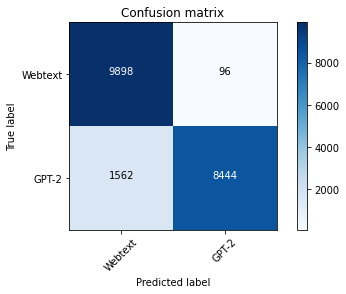

In [25]:
loss, acc, fscore, cm, true_labels, preds = evaluate_confusion_matrix(best_model, test_dataloader)
print("Macro F1 score:", fscore)
print("Classification report:\n", classification_report(true_labels, preds, target_names = ['GTP-2', 'Webtext']))
plot_confusion_matrix(cm, ("Webtext", "GPT-2"))

In [0]:
test_string3 = "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance reforms. We focus mainly on interventions aimed at improving primary and secondary education but consider vocational training interventions briefly. We have not yet completed a report on early childhood (pre-school) interventions. On this page, we focus on evidence from experimental study designs.\n\nThis page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance re..."

test_string4 = "If you look on a board game shelf, how many games will you see with actions based on collaboration, stewardship, generosity, and gratitude? Most likely, you'll find mechanics like attacking, stealing, and backstabbing. Indigenous communities looking to facilitate intergenerational gameplay are thus hard-pressed to find options that reinforce their teachings. In response, communities are developing their own games for passing on teachings in many forms. As espoused by game designer Brenda Romero, the mechanic is the message. And the messages in the board game The Gift of Food—inspired by collaborative game development with Indigenous communities working with the Northwest Indian College—produce culturally responsive gameplay, meaning gameplay that is drawn from and that uplifts the cultures involved.\n\nThe Gift of Food is an ideal example of how culturally responsive board games can function as important pathways for passing on Indigenous ways of knowing, as learning and reinforcin..."

test_string1 = "Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud\n\nJuly 6, 2018"

test_string2 = "Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion."

test_string5 = "Scientists can now visualize and experiment with structures and the dynamics of complex molecular makeup (at atomic-level precision), with real-time multi-user collaboration via the cloud\n\nJuly 6, 2018"

test_string6 = "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance reforms. We focus mainly on interventions aimed at improving primary and secondary education but consider vocational training interventions briefly. We have not yet completed a report on early childhood (pre-school) interventions. On this page, we focus on evidence from experimental study designs."

test_string7 = "If you look on a board game shelf, how many games will you see with actions based on collaboration, stewardship, generosity, and gratitude? Most likely, you'll find mechanics like attacking, stealing, and backstabbing. Indigenous communities looking to facilitate intergenerational gameplay are thus hard-pressed to find options that reinforce their teachings. In response, communities are developing their own games for passing on teachings in many forms. As espoused by game designer Brenda Romero, the mechanic is the message. And the messages in the board game The Gift of Food—inspired by collaborative game development with Indigenous communities working with the Northwest Indian College—produce culturally responsive gameplay, meaning gameplay that is drawn from and that uplifts the cultures involved.\n\nThe Gift of Food is an ideal example of how culturally responsive board games can function as important pathways for passing on Indigenous ways of knowing"

test_strings_list = [test_string1, test_string2, test_string3, test_string4, test_string5, test_string6, " ".join(tokenizer.tokenize(test_string7)[:16])]

In [44]:
i=1
attention_weights = []
for each in test_strings_list:
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  # For every sentence...
  sent = tokenizer.tokenize(each)
  encoded_dict = tokenizer.encode_plus(
                each,                      # Sentence to encode.
                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                max_length = 256,           # Pad & truncate all sentences.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',     # Return pytorch tensors.
          )
    
    # Add the encoded sentence to the list.    
  input_ids = torch.tensor(encoded_dict['input_ids']).to(device)
    
    # And its attention mask (simply differentiates padding from non-padding).
  attention_masks = torch.tensor(encoded_dict['attention_mask']).to(device)

  best_model.eval()

  output, hidden, attentions = best_model(input_ids, token_type_ids=None, 
                      attention_mask=attention_masks)
  # print(attentions[1].shape)
  last_layer_attn = attentions[-1].squeeze(0)
  weights = last_layer_attn.cpu()
  weights = weights[:,0,:].detach().numpy()
  attention_weights.append(weights)
  output = nn.functional.softmax(output)
  probabilities, predicted = torch.max(output.cpu().data, 1)
  print(f"GPT-2_string_{i} is {len(sent)} words long.")
  print(f'The text: "{each}"')
  print(f"The prediction for GPT-2_string_{i} is {predicted.item()} and the model was {round(probabilities.item()*100, 4)}% confident.")
  print("----------")
  i+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


GPT-2_string_1 is 38 words long.
The text: "Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018"
The prediction for GPT-2_string_1 is 0 and the model was 99.439% confident.
----------
GPT-2_string_2 is 46 words long.
The text: "Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion."
The prediction for GPT-2_string_2 is 1 and the model was 99.6138% confident.
----------
GPT-2_string_3 is 179 words long.
The text: "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) 

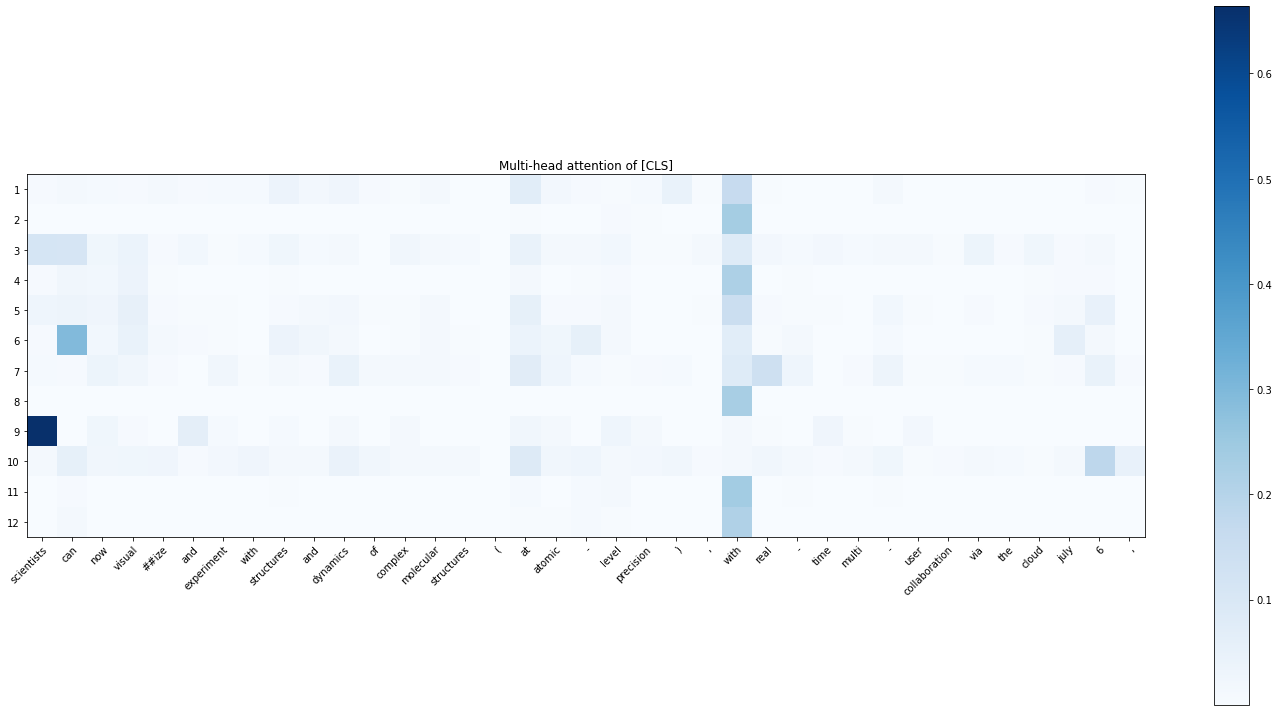

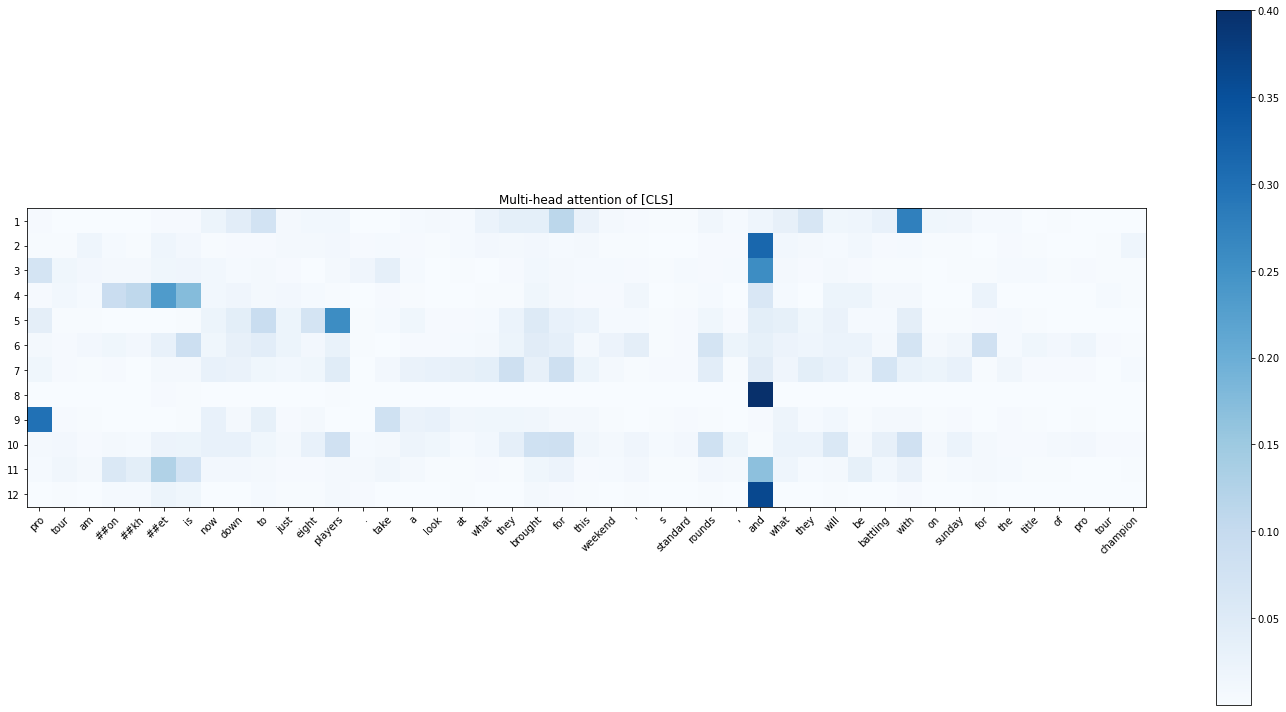

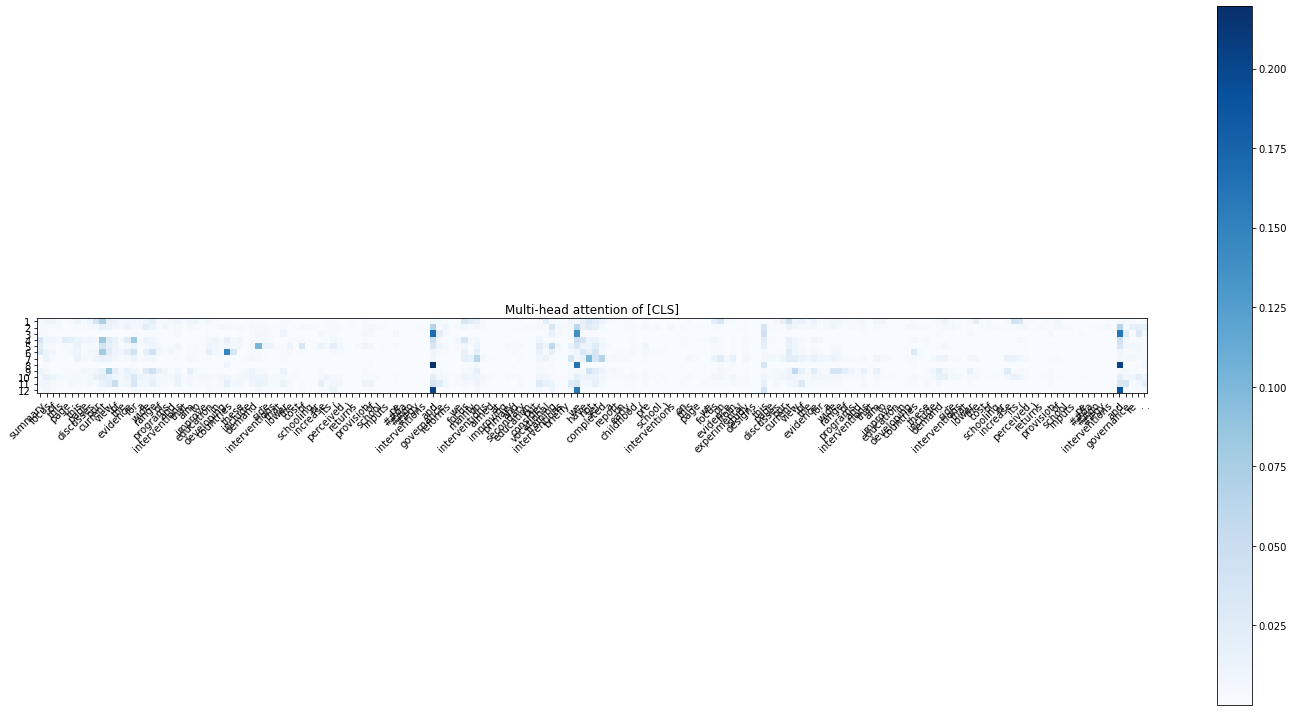

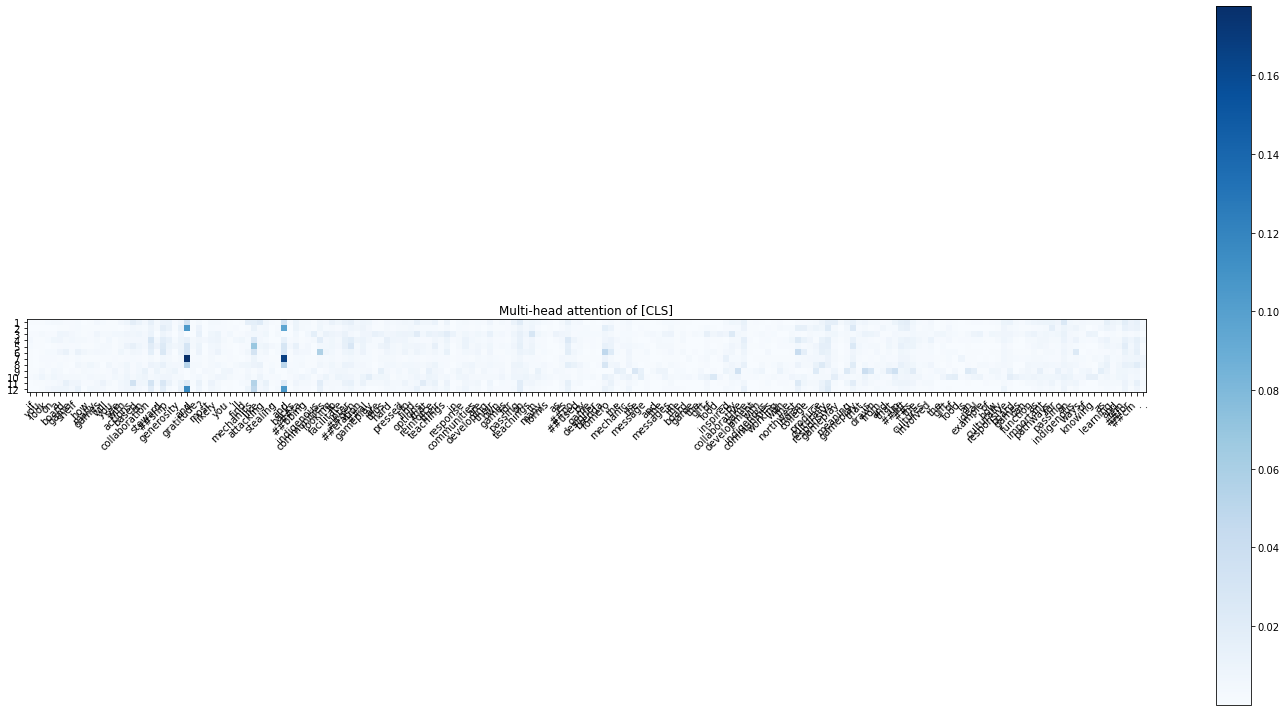

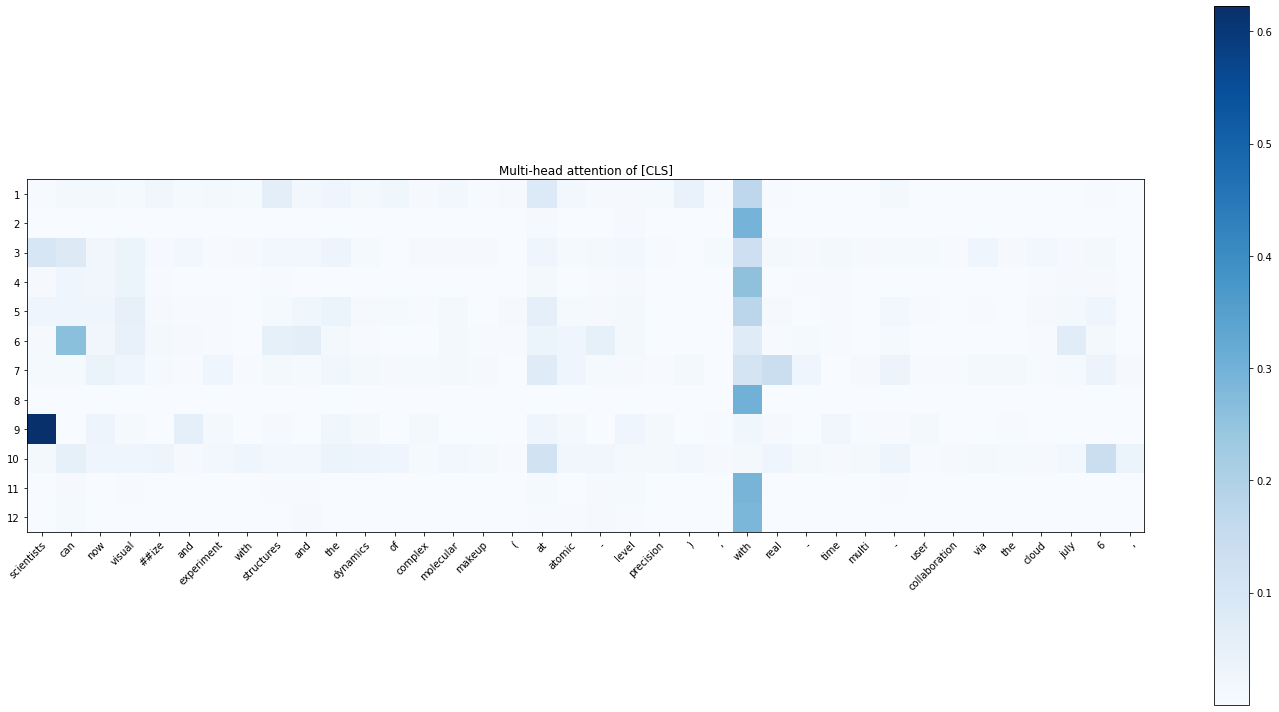

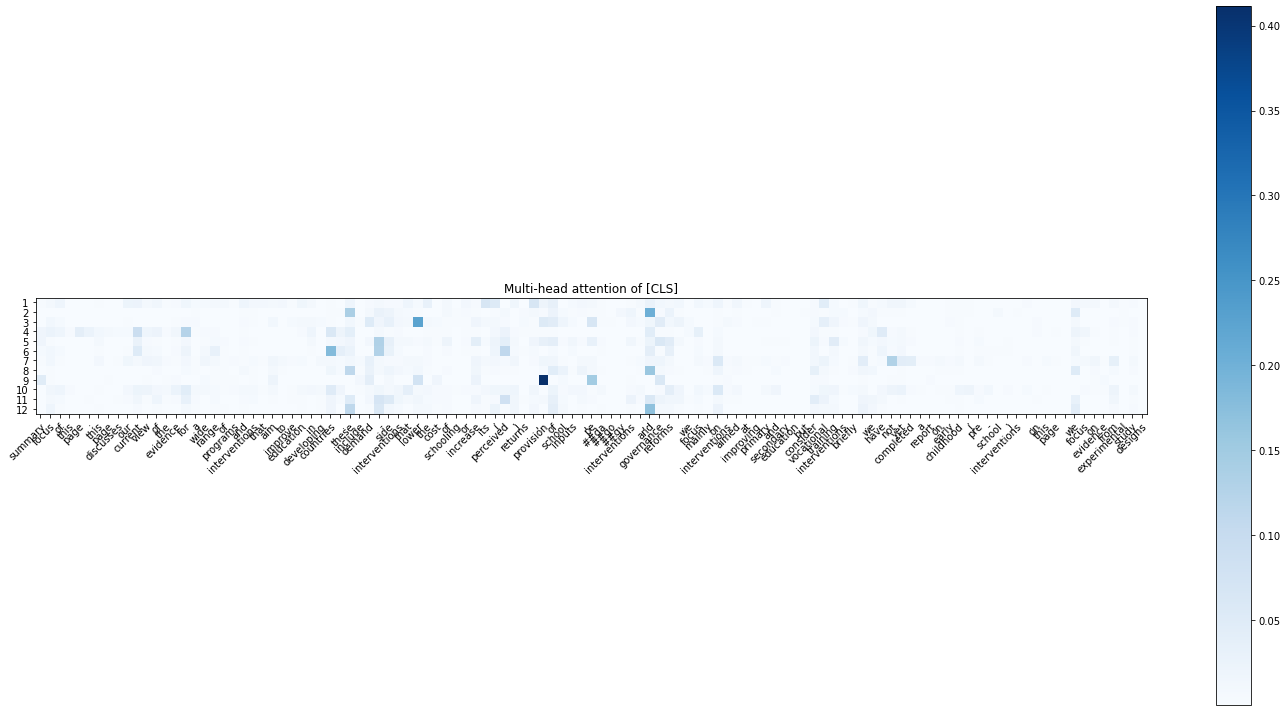

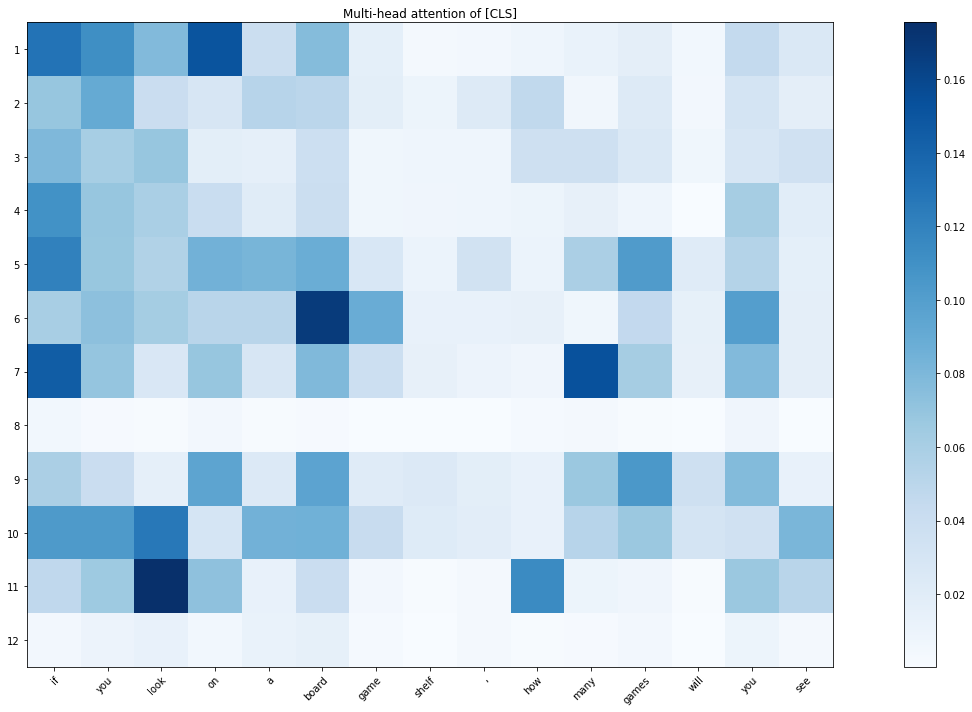

In [45]:
attention_weights[0].shape # 12 heads 128 tokens 
for sent, weights in zip(test_strings_list, attention_weights):
  input_tokens = tokenizer.tokenize(sent)[:256]
  weights = np.array(weights)[:,0:len(input_tokens)-1]
  fig, ax = plt.subplots(figsize = (20, 10))
  im = ax.imshow(weights,cmap=plt.cm.Blues)
  # We want to show all ticks...
  ax.set_xticks(np.arange(len(input_tokens)-1))
  ax.set_yticks(np.arange(12))
  # ... and label them with the respective list entries
  ax.set_xticklabels(input_tokens)
  ax.set_yticklabels([i for i in range(1,13)])
  plt.colorbar(im)
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  ax.set_title("Multi-head attention of [CLS]")
  fig.tight_layout()
  plt.show()

In [46]:
idx = []
for i in range(len(true_labels)):
  if true_labels[i] != preds[i]:
    idx.append(i)
print("Number of wrong prediction:", len(idx))

Number of wrong prediction: 1658


In [47]:
test = pd.read_csv(path+"subset_100k_test.csv", delimiter=',',header=0, names=['content','label'])
wrong_bert = test.iloc[idx]
wrong_bert

,content,label
10,A Maryland couple was arrested for fighting wi...,0
11,Contents show]\n\nOverview Edit\n\n\nIssei Hyo...,0
17,This story takes place after Hanako's good end...,0
20,There are times when the best workout is no wo...,0
27,By: Christina Sarich | Natural Society –\n\nIn...,0
...,...,...
19940,Amnesty said King Salman's signature is all th...,0
19954,Leptin is released by fat cells and travels th...,0
19965,If you have questions about TIF please contact...,0
19969,How can a client feel secure from the potentia...,0


In [48]:
# get statistics on the incorrect predictions
seq_len = []
for sent in wrong_bert['content']:
  tokenized_sent = tokenizer.tokenize(sent)
  seq_len.append(len(tokenized_sent))
wrong_bert['sentence length'] = seq_len

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f59cf070358>,
      dtype=object)

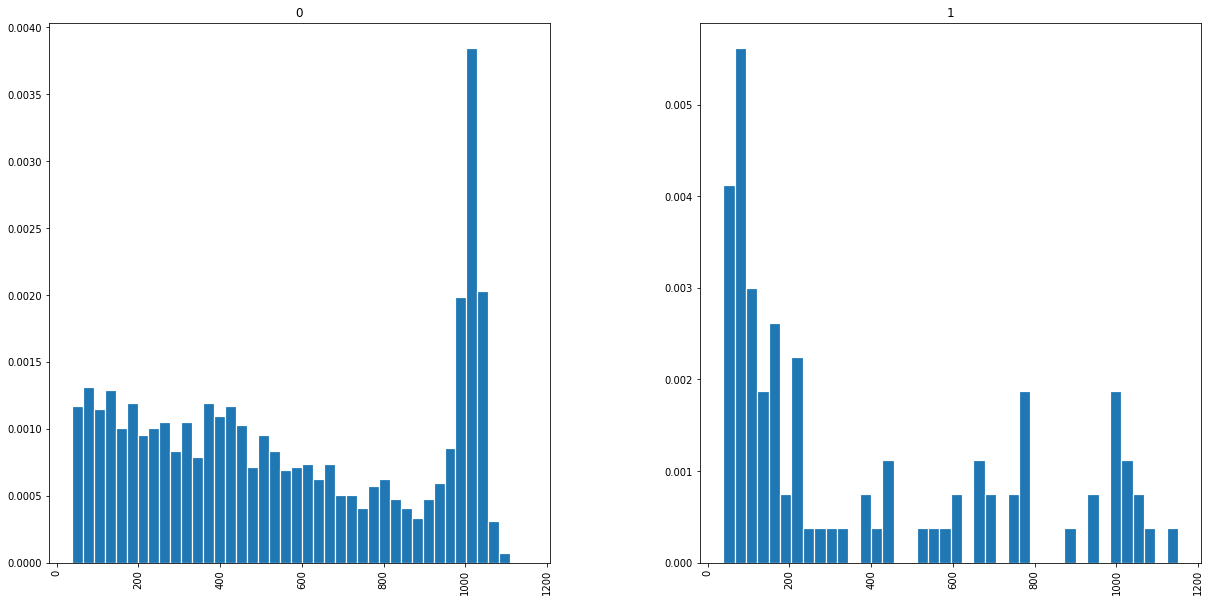

In [49]:
wrong_bert.hist(by = 'label', column = 'sentence length', sharex = 'col',
                                   figsize = (20,10), 
                                   bins = 40,
                                   edgecolor='white', 
                                   linewidth=1.2,
                density = True)